<a href="https://colab.research.google.com/github/SriSaiRatnaAbhishekKosuri128922/brain-tumor-detection/blob/main/Brain_Tumor_Detection_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧠 Brain Tumor Detection Based on Deep Learning Approaches and MRI

---

### Project By:  
**Sri Sai Ratna Abhishek Kosuri**  
B.Tech CSE with AI & ML  
VIT-AP University

---

This project was independently developed as part of my final year academic work.


## 🧾 Introduction

Brain tumors are a severe health concern and early diagnosis is crucial for effective treatment. Manual analysis of MRI scans can be time-consuming and prone to errors, which is where deep learning models can assist significantly.

This project aims to build a deep learning model using PyTorch to classify brain tumor MRI images into appropriate categories. The approach involves dataset preprocessing, augmentation using Albumentations, model architecture design, and evaluation on performance metrics such as accuracy and ROC-AUC.

The dataset is downloaded using the Kaggle API and contains labeled MRI images.

---


## 🎯 Objective

The main objective of this project is to:

- Develop a deep learning model to classify brain tumor MRI scans.
- Apply image preprocessing and augmentation techniques to enhance data quality.
- Train and evaluate the model using performance metrics such as accuracy, confusion matrix, and ROC-AUC score.
- Demonstrate the feasibility of AI-assisted diagnosis in medical imaging.

---


## 🛠️ Tools & Technologies

The project utilizes the following tools, libraries, and platforms:

- **Programming Language:** Python  
- **Frameworks & Libraries:**  
  - PyTorch, Torchvision, Albumentations, TorchSummary, TorchViz  
  - TensorFlow (for comparison/utility purposes)  
  - OpenCV, PIL (image processing)  
  - Pandas, NumPy (data manipulation)  
  - Matplotlib, Seaborn (visualization)  
- **Machine Learning Utilities:**  
  - Scikit-learn (model evaluation, data splitting)  
- **Platform:** Google Colab  
- **Data Source:** [Kaggle - Brain Tumor MRI Scans](https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans)

---


# Importing Required Libraries

In [124]:
# Standard Libraries
import os
import warnings
warnings.filterwarnings('ignore')

# Image Processing
import cv2
from PIL import Image

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Random, Zip File, and TensorFlow Utilities
import random
import zipfile
import tensorflow as tf

# Deep Learning Libraries (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import lr_scheduler
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Utility Libraries
import copy
import time

# Install additional packages
!pip install torchsummary
from torchsummary import summary

!pip install torchviz
from torchviz import make_dot


# Device Selection

In [125]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cuda


# Kaggle API Setup

In [126]:
# 🔑 Setting up Kaggle API to access the dataset
# Create the Kaggle directory
os.makedirs("/root/.kaggle", exist_ok=True)
# Move kaggle.json to the correct folder
os.system("cp /content/kaggle.json /root/.kaggle/")
# Set permissions to avoid API errors
os.chmod("/root/.kaggle/kaggle.json", 600)


In [127]:
!kaggle datasets list -s "brain tumor MRI"


ref                                                         title                                                 size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
masoudnickparvar/brain-tumor-mri-dataset                    Brain Tumor MRI Dataset                          155791278  2021-09-24 12:43:45.510000         120274        885  0.875            
sartajbhuvaji/brain-tumor-classification-mri                Brain Tumor Classification (MRI)                  91002358  2020-05-24 16:24:55.367000          80191        758  0.875            
navoneel/brain-mri-images-for-brain-tumor-detection         Brain MRI Images for Brain Tumor Detection        15828590  2019-04-14 15:15:54.730000         134106       1458  0.5              
rm1000/brain-tumor-mri-scans            

In [128]:
# Download dataset using Kaggle API
!kaggle datasets download -d rm1000/brain-tumor-mri-scans


Dataset URL: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans
License(s): CC0-1.0
brain-tumor-mri-scans.zip: Skipping, found more recently modified local copy (use --force to force download)


# Load and Explore the Dataset

📦 Unzip Dataset and Define Paths

In [129]:
# Unzip the dataset
with zipfile.ZipFile("brain-tumor-mri-scans.zip", "r") as zip_ref:
    zip_ref.extractall("brain_tumor_dataset")

# Define dataset path
dataset_path = "/content/brain_tumor_dataset"


📁 Check Dataset Structure

In [130]:
print("Dataset files and structure:")
!ls brain_tumor_dataset


Dataset files and structure:
glioma	healthy  meningioma  pituitary


🔍 View Class Names

In [131]:
class_names = os.listdir(dataset_path)
class_names.sort()
print(class_names)


['glioma', 'healthy', 'meningioma', 'pituitary']


📊 Count Images in Each Class

In [132]:
# Initialize class count dictionary
categories = {"glioma": 0, "healthy": 0, "meningioma": 0, "pituitary": 0}

# Count images in each class
for category in categories:
    category_path = os.path.join(dataset_path, category)
    categories[category] = len(os.listdir(category_path))
    print(f"📂 {category}: {categories[category]} images")

print(f"\n📦 Total Images: {sum(categories.values())}")


📂 glioma: 1621 images
📂 healthy: 2000 images
📂 meningioma: 1645 images
📂 pituitary: 1757 images

📦 Total Images: 7023


📈 Visualize Class Distribution

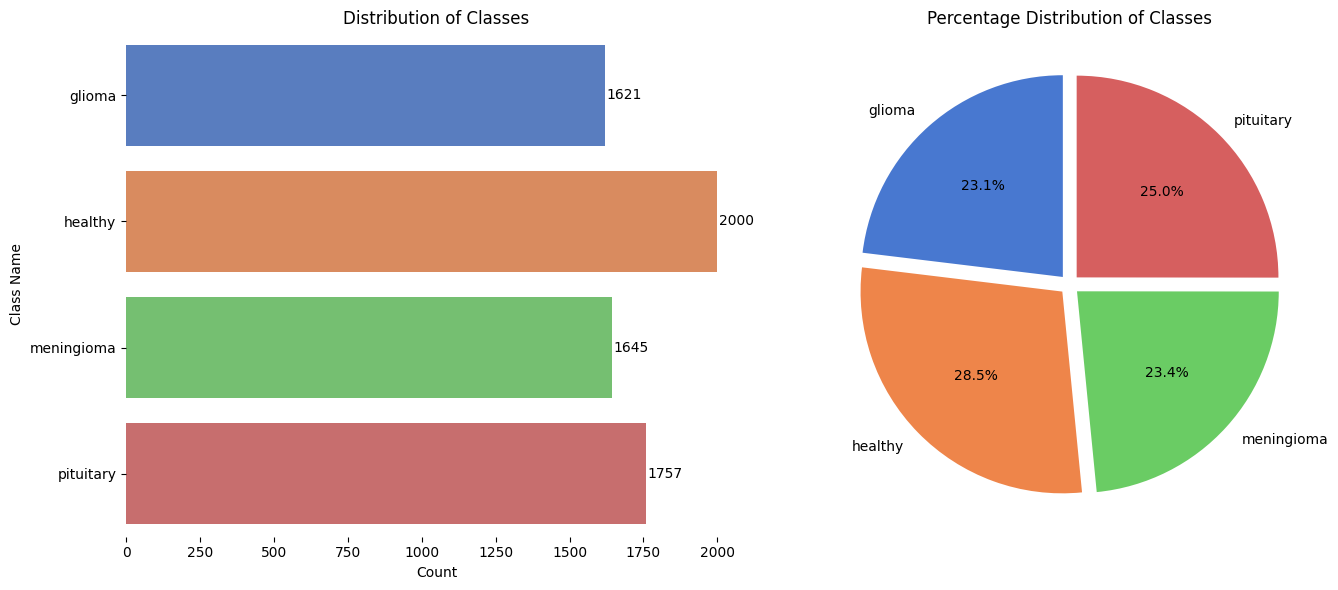

In [133]:
# Create a DataFrame for plotting
df = pd.DataFrame({
    'Class': list(categories.keys()),
    'Count': list(categories.values())
})

# Plotting
plt.figure(figsize=(14, 6))

# Barplot
plt.subplot(1, 2, 1)
sns.barplot(y='Class', x='Count', data=df, palette='muted')
plt.title('Distribution of Classes')
plt.xlabel('Count')
plt.ylabel('Class Name')
ax = plt.gca()
for p in ax.patches:
    width = p.get_width()
    ax.annotate(f'{int(width)}', (width + 5, p.get_y() + p.get_height() / 2),
                ha='left', va='center')
sns.despine(left=True, bottom=True)

# Pie Chart
plt.subplot(1, 2, 2)
df.set_index('Class')['Count'].plot.pie(autopct='%1.1f%%',
                                        colors=sns.color_palette('muted'),
                                        startangle=90,
                                        explode=[0.05]*len(df))
plt.title('Percentage Distribution of Classes')
plt.ylabel('')

plt.tight_layout()
plt.show()


🖼️ Preview a Sample Image

In [134]:
img_path = "/content/brain_tumor_dataset/glioma/0812.jpg"
img = tf.io.read_file(img_path)
img = tf.image.decode_jpeg(img, channels=3)
print("Sample image shape:", img.shape)


Sample image shape: (512, 512, 3)


🔍 List Extracted Files

In [135]:
# List all image paths for review/debug
for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/brain_tumor_dataset/glioma/1277.jpg
/content/brain_tumor_dataset/glioma/0722.jpg
/content/brain_tumor_dataset/glioma/1034.jpg
/content/brain_tumor_dataset/glioma/1489.jpg
/content/brain_tumor_dataset/glioma/0740.jpg
/content/brain_tumor_dataset/glioma/1223.jpg
/content/brain_tumor_dataset/glioma/0286.jpg
/content/brain_tumor_dataset/glioma/1266.jpg
/content/brain_tumor_dataset/glioma/0793.jpg
/content/brain_tumor_dataset/glioma/1603.jpg
/content/brain_tumor_dataset/glioma/1303.jpg
/content/brain_tumor_dataset/glioma/0650.jpg
/content/brain_tumor_dataset/glioma/1235.jpg
/content/brain_tumor_dataset/glioma/0648.jpg
/content/brain_tumor_dataset/glioma/0066.jpg
/content/brain_tumor_dataset/glioma/0323.jpg
/content/brain_tumor_dataset/glioma/1093.jpg
/content/brain_tumor_dataset/glioma/0033.jpg
/content/brain_tumor_dataset/glioma/1496.jpg
/content/brain_tumor_dataset/glioma/0602.jpg
/content/brain_tumor_dataset/glioma/1120.jpg
/content/brain_tumor_dataset/glioma/1448.jpg
/content/b

# Dataset Transformations and DataLoader Preparation

⚙️ Hyperparameters

In [136]:
# Define global parameters
batch_size = 8
img_size = 224
num_epochs = 45


Data Augmentation using Albumentations

In [137]:
data_transforms = {
    'train': A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(),
        A.RandomBrightnessContrast(),
        A.Rotate(limit=15),
        A.CoarseDropout(max_holes=1, max_height=16, max_width=16, fill_value=0),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]),
    'val': A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
}


Custom Dataset Loader

In [138]:
class CustomImageDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageDataset, self).__init__(root, transform=None)
        self.custom_transform = transform

    def __getitem__(self, index):
        image, label = super(CustomImageDataset, self).__getitem__(index)
        image = np.array(image)
        if self.custom_transform:
            augmented = self.custom_transform(image=image)
            image = augmented['image']
        return image, label

Dataset Loading and Splitting

In [139]:
full_dataset = CustomImageDataset(dataset_path, transform=data_transforms['train'])

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

val_dataset.dataset.custom_transform = data_transforms['val']
test_dataset.dataset.custom_transform = data_transforms['val']

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print dataset information for the report
print("Dataset Summary:\n")
print(f"Total Images: {len(full_dataset)}\n")
print(f"Training Set Size: {len(train_dataset)} (70%)\n")
print(f"Validation Set Size: {len(val_dataset)} (15%)\n")
print(f"Test Set Size: {len(test_dataset)} (15%)\n")

print("\nDataLoader Details:\n")
print(f"Train DataLoader: batch_size={batch_size}, shuffle=True\n")
print(f"Validation DataLoader: batch_size={batch_size}, shuffle=False\n")
print(f"Test DataLoader: batch_size={batch_size}, shuffle=False\n")

Dataset Summary:

Total Images: 7023

Training Set Size: 4916 (70%)

Validation Set Size: 1053 (15%)

Test Set Size: 1054 (15%)


DataLoader Details:

Train DataLoader: batch_size=8, shuffle=True

Validation DataLoader: batch_size=8, shuffle=False

Test DataLoader: batch_size=8, shuffle=False



# Dataset Pie Chart Overview

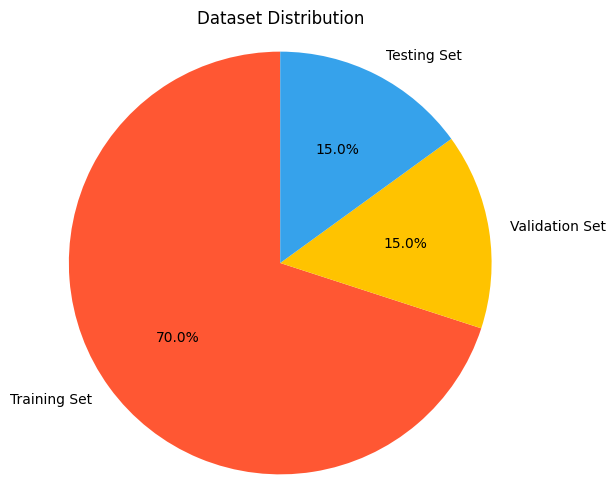

In [140]:
# Data for the pie chart
labels = ['Training Set', 'Validation Set', 'Testing Set']
sizes = [len(train_dataset), len(val_dataset), len(test_dataset)]
colors = ['#FF5733', '#FFC300', '#36A2EB']

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Dataset Distribution')
plt.axis('equal')
plt.show()

# Class Distribution in Train, Val, Test

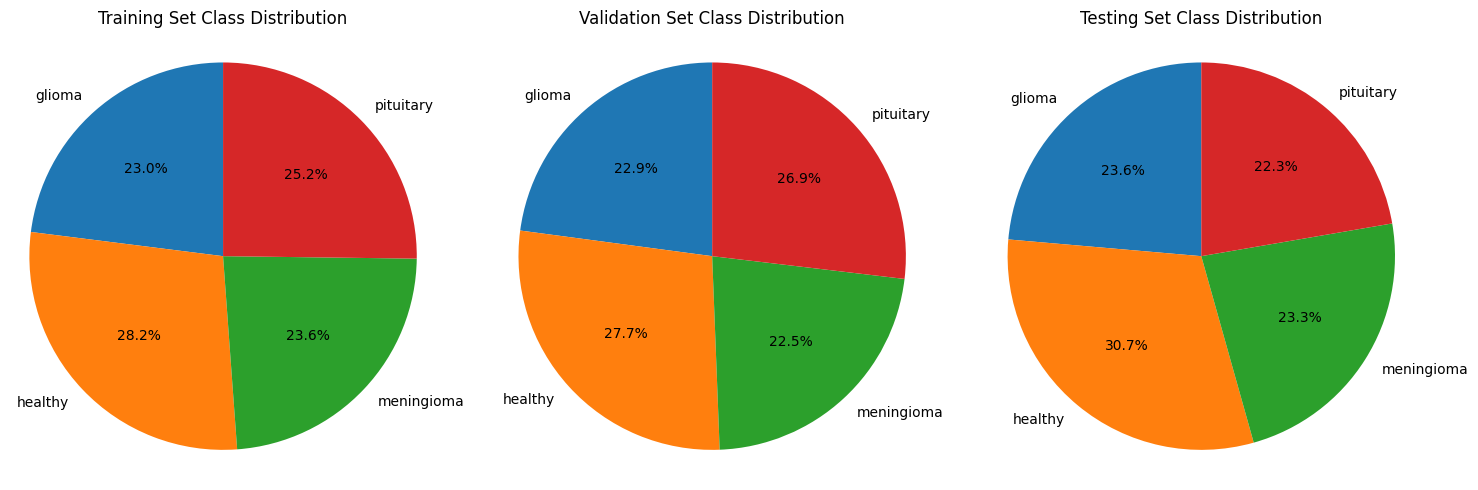

In [141]:
def get_class_distribution(dataset):
    class_counts = {0: 0, 1: 0, 2: 0, 3: 0}
    for _, label in dataset:
        class_counts[label] += 1
    return list(class_counts.values())

# Get class distributions for each set
train_dist = get_class_distribution(train_dataset)
val_dist = get_class_distribution(val_dataset)
test_dist = get_class_distribution(test_dataset)

# Create pie charts
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Training set pie chart
axs[0].pie(train_dist, labels=class_names, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Training Set Class Distribution')

# Validation set pie chart
axs[1].pie(val_dist, labels=class_names, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Validation Set Class Distribution')

# Testing set pie chart
axs[2].pie(test_dist, labels=class_names, autopct='%1.1f%%', startangle=90)
axs[2].set_title('Testing Set Class Distribution')

for ax in axs:
    ax.axis('equal')

plt.tight_layout()
plt.show()

# Image Size Statistics

In [142]:
image_sizes = []  # Collect image sizes

for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        img_path = os.path.join(dirname, filename)
        img = Image.open(img_path)
        image_sizes.append(img.size)

# Analyze and print image size statistics
image_sizes_df = pd.DataFrame(image_sizes, columns=['Width', 'Height'])
print("\nImage Size Statistics:")
print(image_sizes_df.describe())


Image Size Statistics:
             Width       Height
count  7023.000000  7023.000000
mean    445.891499   448.346860
std     132.328035   126.282922
min     150.000000   168.000000
25%     393.000000   403.500000
50%     512.000000   512.000000
75%     512.000000   512.000000
max    1920.000000  1446.000000


# Correlation Matrix, PCA, and t-SNE

Correlation Matrix and Heatmap

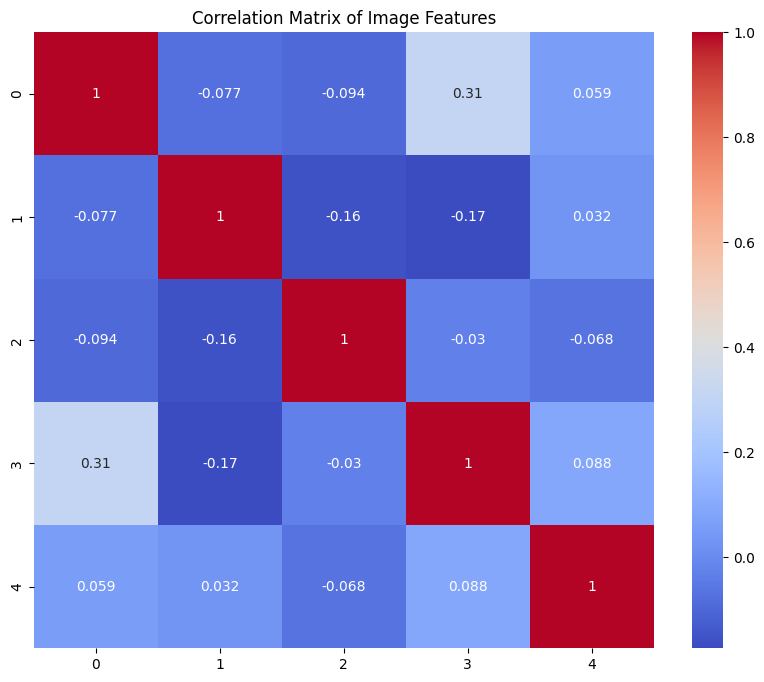

In [143]:
# Simulated features for illustration
image_features = np.random.rand(100, 5)

# Calculate Correlation Matrix
correlation_matrix = np.corrcoef(image_features, rowvar=False)

# Visualize using heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Image Features')
plt.show()

Principal Component Analysis (PCA)

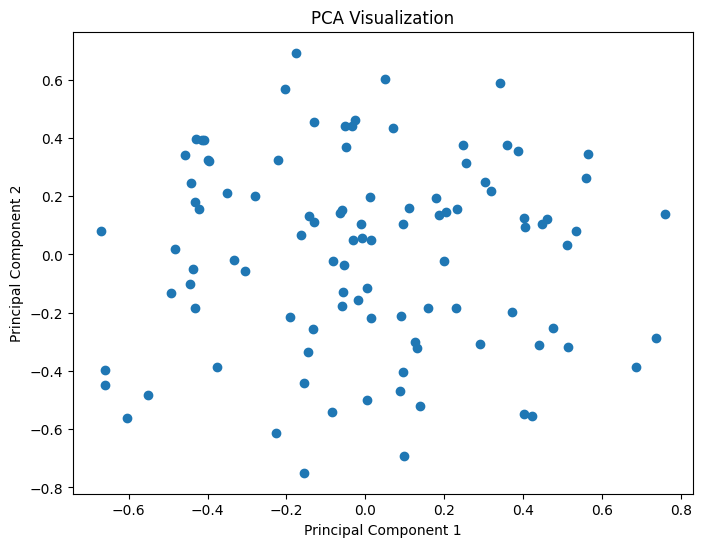

In [144]:
# Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(image_features)

# Visualize principal components
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

t-distributed Stochastic Neighbor Embedding (t-SNE)

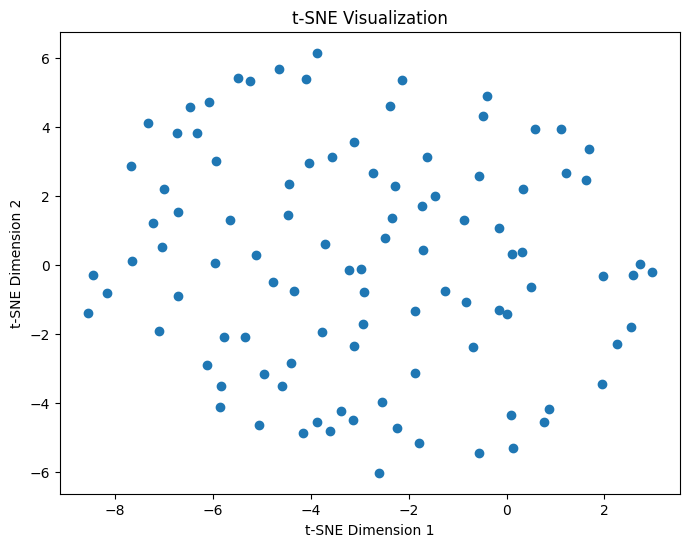

In [145]:
# Perform t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(image_features)

# Visualize t-SNE results
plt.figure(figsize=(8, 6))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# Class Samples Visualization

Displaying Raw Image Samples per Class

🔹 Purpose: Displays num_samples original images from each class folder to visually inspect the dataset content.

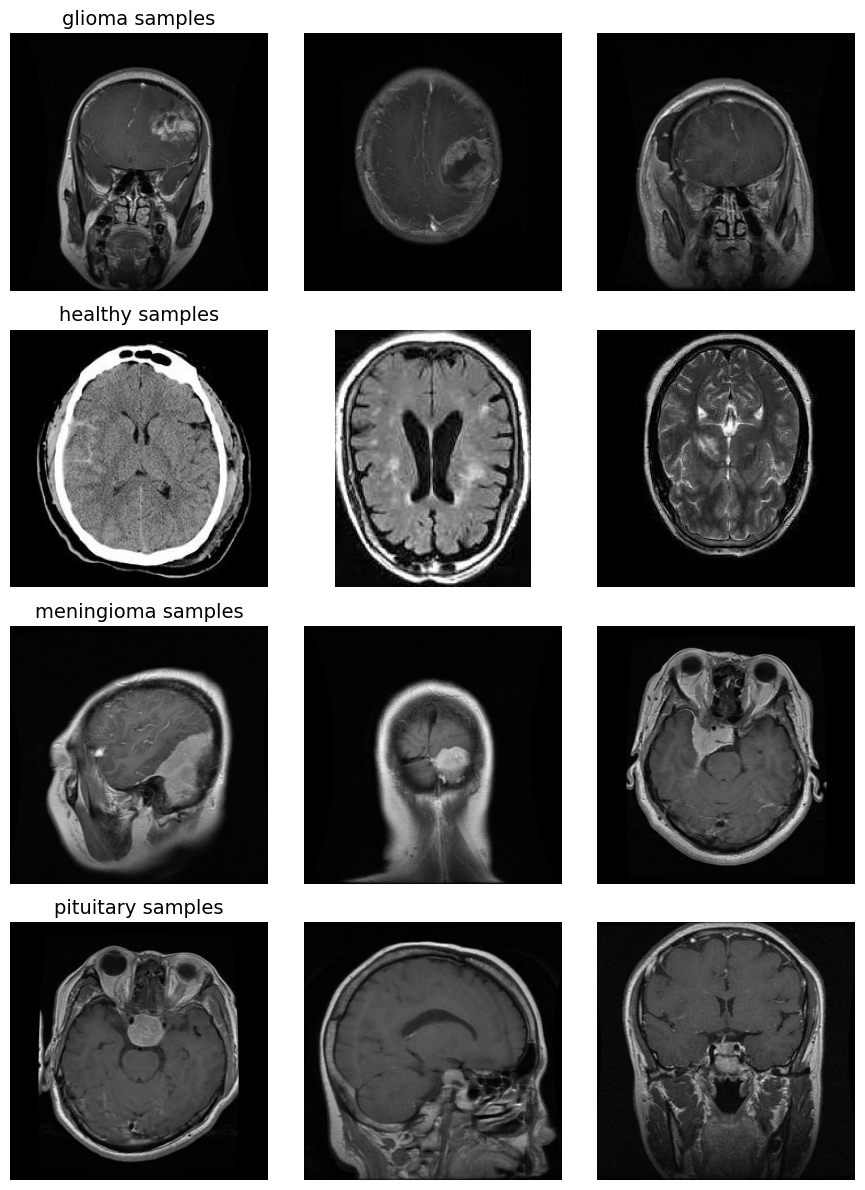

In [146]:
def show_class_samples(dataset_path, classes, num_samples=3):
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(num_samples * 3, len(classes) * 3))
    for i, cls in enumerate(classes):
        class_dir = os.path.join(dataset_path, cls)
        images = random.sample(os.listdir(class_dir), min(num_samples, len(os.listdir(class_dir))))
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_dir, img_name)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                 axes[i, j].set_title(f"{cls} samples", fontsize=14)
    plt.tight_layout()
    plt.show()

# Call the function
show_class_samples(dataset_path, class_names)

Displaying Augmented Samples Using Albumentations

🔹 Purpose: Shows transformed images after applying data augmentation pipeline. Ensures that transformations like rotation, shift, flip, etc., are working as intended.

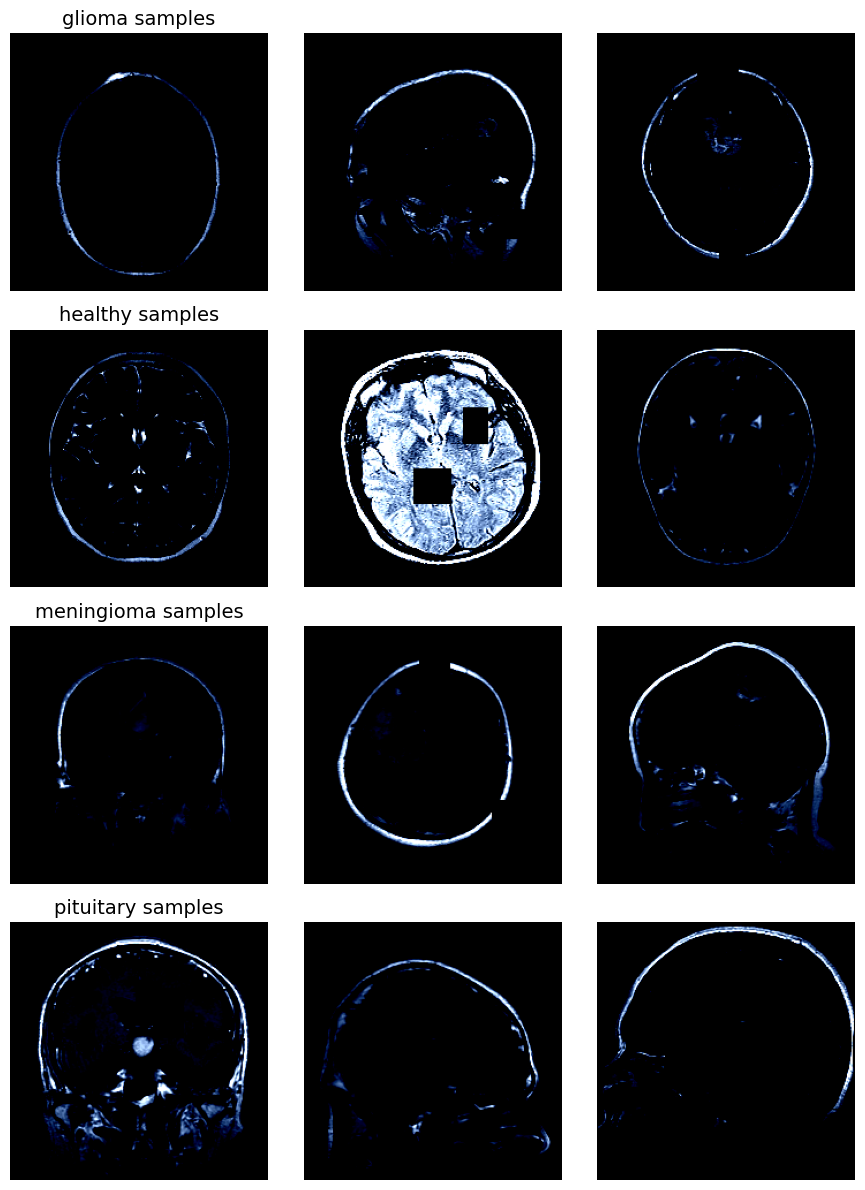

In [147]:
def show_augmented_samples(dataset_path, classes, num_samples=3):
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(num_samples * 3, len(classes) * 3))

    for i, cls in enumerate(classes):
        class_dir = os.path.join(dataset_path, cls)  # Get directory for current class
        image_files = [
            os.path.join(class_dir, filename)
            for filename in os.listdir(class_dir)
            if filename.endswith(('.jpg', '.jpeg', '.png'))
        ]

        selected_images = random.sample(image_files, num_samples)

        for j, img_path in enumerate(selected_images):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

            augmented_img = data_transforms['train'](image=img)['image']

            # Display augmented image
            axes[i, j].imshow(augmented_img.permute(1, 2, 0))
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(f"{cls} samples", fontsize=14)

    plt.tight_layout()
    plt.show()


# Call the function
show_augmented_samples(dataset_path, class_names)

Checking Image Batch Shape from DataLoader

🔹 Purpose: Confirms the shape of input image tensors loaded by the train_loader. Useful for debugging batch size, channel format, or preprocessing mismatches.

In [148]:
for images, labels in train_loader:
    print("Batch image shape:", images.shape)
    break


Batch image shape: torch.Size([8, 3, 224, 224])


Original vs Transformed Image

TensorFlow Image shape: (512, 512, 3)
PyTorch Image shape: torch.Size([3, 224, 224])


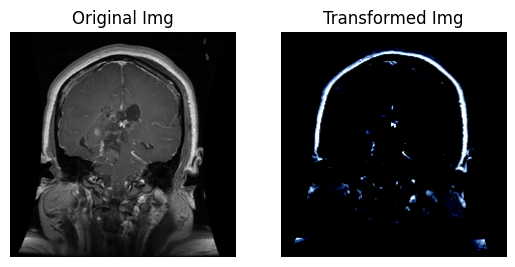

In [149]:
# 1. Load the image using TensorFlow
img_path = "/content/brain_tumor_dataset/glioma/0812.jpg"
img_tf = tf.io.read_file(img_path)
img_tf = tf.image.decode_jpeg(img_tf, channels=3)
print("TensorFlow Image shape:", img_tf.shape)

# 2. Define the transformations used by PyTorch DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 3. Convert the TensorFlow tensor to a PIL image
img_pil = Image.fromarray(img_tf.numpy())

# 4. Apply the PyTorch transforms
img_torch = transform(img_pil)
print("PyTorch Image shape:", img_torch.shape)

# 5. Display the original and transformed images

#  Original image
plt.subplot(1, 2, 1)
plt.imshow(img_tf.numpy())
plt.title("Original Img")
plt.axis('off')

#  Transformed image
plt.subplot(1, 2, 2)
plt.imshow(img_torch.permute(1, 2, 0).numpy())
plt.title("Transformed Img")
plt.axis('off')

plt.show()

# Model Architecture (ResNet50)

In [150]:
# Resnet50
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
model = model.to(device)

Loss Function, Optimizer, and Scheduler

In [151]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Training and Evaluation Functions

Training Function with Early Stopping and Scheduler

🔹 Purpose: Trains the model while tracking metrics, implementing early stopping, and using a scheduler to adapt learning rate.

In [152]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Early stopping variables
    early_stopping_counter = 0
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        # --- Training phase ---
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # --- Validation phase ---
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                correct += (outputs.argmax(dim=1) == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total

        print(f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Record history
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # --- Early stopping ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

            if early_stopping_counter >= patience:
                print(f"Early stopping triggered after {patience} epochs without improvement!")
                break

        # Step the scheduler
        scheduler.step(val_loss)

    model.load_state_dict(best_model_wts)
    return model, history


Model Evaluation Function

🔹 Purpose: Evaluates model performance on any dataset (train/val/test), returning loss and accuracy.

In [153]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / len(data_loader), 100 * correct / total


Model Summary (Using torchsummary)

🔹 Purpose: Prints the model architecture layer-by-layer with output shapes and parameter counts (like model.summary() in Keras).

In [154]:
# Print model summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Print Layer Names in Model

🔹 Purpose: Prints all named modules (layers) in the model. Useful for inspection or modification of specific layers.

In [155]:
for i, (name, _) in enumerate(model.named_modules()):
    print(f"layer{i}: {name}")

layer0: 
layer1: conv1
layer2: bn1
layer3: relu
layer4: maxpool
layer5: layer1
layer6: layer1.0
layer7: layer1.0.conv1
layer8: layer1.0.bn1
layer9: layer1.0.conv2
layer10: layer1.0.bn2
layer11: layer1.0.conv3
layer12: layer1.0.bn3
layer13: layer1.0.relu
layer14: layer1.0.downsample
layer15: layer1.0.downsample.0
layer16: layer1.0.downsample.1
layer17: layer1.1
layer18: layer1.1.conv1
layer19: layer1.1.bn1
layer20: layer1.1.conv2
layer21: layer1.1.bn2
layer22: layer1.1.conv3
layer23: layer1.1.bn3
layer24: layer1.1.relu
layer25: layer1.2
layer26: layer1.2.conv1
layer27: layer1.2.bn1
layer28: layer1.2.conv2
layer29: layer1.2.bn2
layer30: layer1.2.conv3
layer31: layer1.2.bn3
layer32: layer1.2.relu
layer33: layer2
layer34: layer2.0
layer35: layer2.0.conv1
layer36: layer2.0.bn1
layer37: layer2.0.conv2
layer38: layer2.0.bn2
layer39: layer2.0.conv3
layer40: layer2.0.bn3
layer41: layer2.0.relu
layer42: layer2.0.downsample
layer43: layer2.0.downsample.0
layer44: layer2.0.downsample.1
layer45: la

Visualize Model Architecture as a Graph (Using torchviz)

🔹 Purpose: Generates a graph-based visualization of the model's computation graph and saves it as an image.

In [156]:
# Create a dummy input tensor
dummy_input = torch.randn(1, 3, 224, 224, device=device)  # Input shape for image models

# Generate the visualization
dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))

# Save the visualization to a PNG file
dot.render("model", format="png")

# Display it inline in a Jupyter/Colab notebook
from IPython.display import Image
display(Image(filename='model.png'))


# Training the Model

In [157]:
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

Epoch 1/45
Train Acc: 74.04%, Val Acc: 83.95%, Train Loss: 0.6893, Val Loss: 0.4379
Epoch 2/45
Train Acc: 82.26%, Val Acc: 67.14%, Train Loss: 0.4755, Val Loss: 0.7984
Epoch 3/45
Train Acc: 85.37%, Val Acc: 79.30%, Train Loss: 0.3933, Val Loss: 0.5485
Epoch 4/45
Train Acc: 88.47%, Val Acc: 85.85%, Train Loss: 0.3212, Val Loss: 0.4613
Epoch 5/45
Train Acc: 89.50%, Val Acc: 91.55%, Train Loss: 0.2889, Val Loss: 0.2401
Epoch 6/45
Train Acc: 91.31%, Val Acc: 92.88%, Train Loss: 0.2391, Val Loss: 0.2109
Epoch 7/45
Train Acc: 92.17%, Val Acc: 85.19%, Train Loss: 0.2247, Val Loss: 0.4598
Epoch 8/45
Train Acc: 94.28%, Val Acc: 91.74%, Train Loss: 0.1534, Val Loss: 0.2275
Epoch 9/45
Train Acc: 94.12%, Val Acc: 87.65%, Train Loss: 0.1647, Val Loss: 0.4243
Epoch 10/45
Train Acc: 95.38%, Val Acc: 94.68%, Train Loss: 0.1285, Val Loss: 0.1459
Epoch 11/45
Train Acc: 95.93%, Val Acc: 94.49%, Train Loss: 0.1216, Val Loss: 0.1446
Epoch 12/45
Train Acc: 97.46%, Val Acc: 94.78%, Train Loss: 0.0749, Val Lo

# Evaluating the Model on the Test Set

In [158]:
test_loss, test_acc = evaluate_model(model, test_loader, criterion)
print(f"Test Accuracy: {test_acc}%, Test Loss: {test_loss}")

Test Accuracy: 97.05882352941177%, Test Loss: 0.12007364965586131


# Training and Validation Metrics for Model Comparison

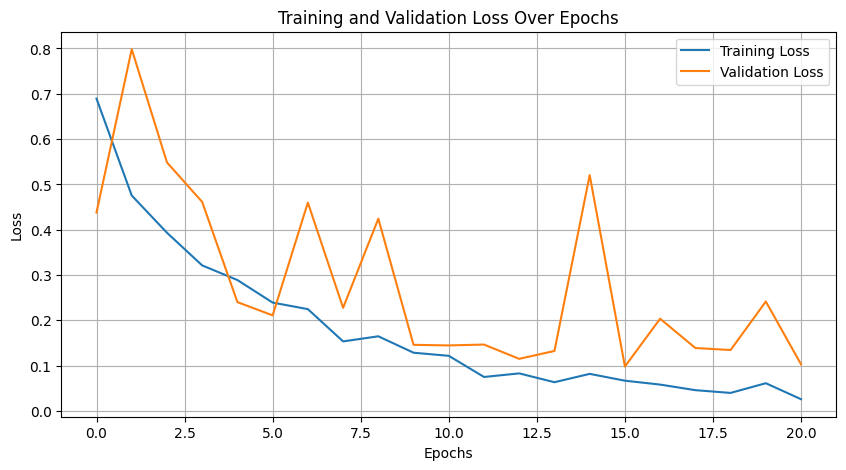

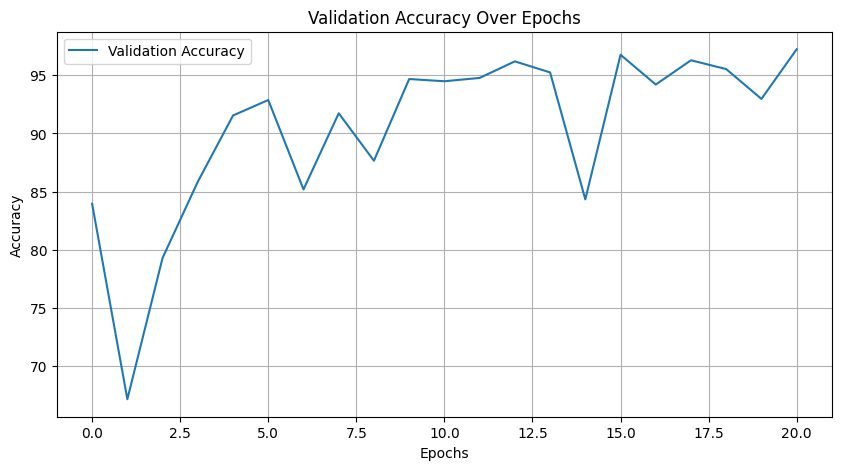

In [159]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
#=============================================================
plt.figure(figsize=(10, 5))
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Model Evaluation and Performance Analysis

Confusion Matrix, Classification Report and Predictions Section

In [160]:
def plot_confusion_matrix(model, data_loader, classes):
    model.eval()

    all_preds = []  # Predicted labels
    all_labels = []  # True labels
    all_probs = []  # Store probabilities for ROC-AUC calculation

    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(outputs.softmax(dim=1).cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return all_preds, all_labels, all_probs

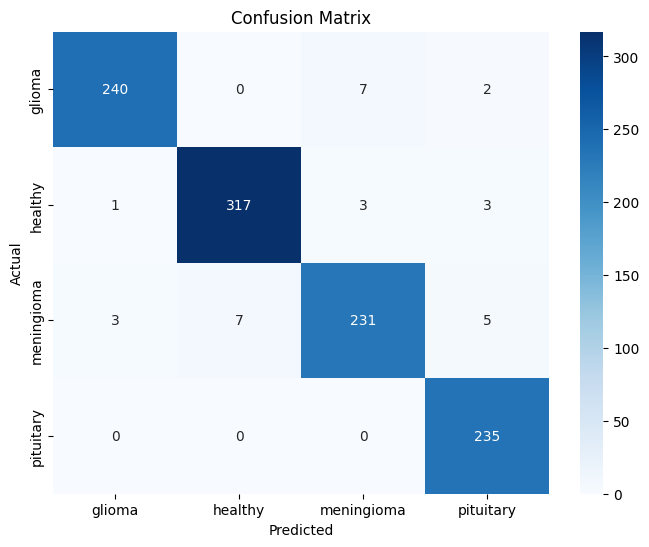

In [161]:
all_preds, all_labels, all_probs = plot_confusion_matrix(model, test_loader, class_names)

In [162]:
# Generate classification metrics
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

      glioma       0.98      0.96      0.97       249
     healthy       0.98      0.98      0.98       324
  meningioma       0.96      0.94      0.95       246
   pituitary       0.96      1.00      0.98       235

    accuracy                           0.97      1054
   macro avg       0.97      0.97      0.97      1054
weighted avg       0.97      0.97      0.97      1054



Top-k Accuracy

🔹 Top-k accuracy measures the accuracy of the model when the true label is among the top-k predicted classes. This is especially useful for multi-class classification problems where the model might be correct but doesn't have the highest probability in the top-1 predicted class.

In [163]:
def top_k_accuracy(model, data_loader, k=5):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Ensure k does not exceed the number of classes
            k = min(k, outputs.size(1))  # outputs.size(1) is the number of classes
            _, top_k_preds = outputs.topk(k, 1, True, True)
            correct += (top_k_preds == labels.view(-1, 1).expand_as(top_k_preds)).sum().item()
            total += labels.size(0)
    top_k_acc = correct / total
    print(f'Top-{k} Accuracy: {top_k_acc * 100:.2f}%')
    return top_k_acc

top_k_accuracy(model, test_loader, k=5)

Top-4 Accuracy: 100.00%


1.0

Precision, Recall, and F1-Score Calculation

🔹 Precision, recall, and F1-score are essential metrics for understanding the model's performance in both imbalanced and balanced datasets. These metrics are included in the classification report but can be explicitly computed for deeper insight.

In [164]:
from sklearn.metrics import precision_score, recall_score, f1_score

def precision_recall_f1(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')
    return precision, recall, f1

precision, recall, f1 = precision_recall_f1(model, test_loader)

Precision: 0.9707, Recall: 0.9706, F1-Score: 0.9705


Model Performance on a Validation Set

🔹 When you have a separate validation dataset, it can be useful to evaluate the model performance on it separately to detect overfitting. This can be done by using evaluate_model() function and passing the validation dataset to it.

In [165]:
# Evaluate the model on the validation set
val_loss, val_acc = evaluate_model(model, val_loader, criterion)
print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')


Validation Loss: 0.0980, Validation Accuracy: 96.77%


Class-wise Accuracy

🔹 For a more detailed analysis, checking how well a model performs on each individual class by calculating the accuracy for each class in the dataset.

In [166]:
def classwise_accuracy(model, data_loader, class_names):
    model.eval()
    correct = [0] * len(class_names)
    total = [0] * len(class_names)
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for i in range(len(labels)):
                total[labels[i]] += 1
                if preds[i] == labels[i]:
                    correct[labels[i]] += 1
    classwise_acc = [correct[i] / total[i] * 100 if total[i] > 0 else 0 for i in range(len(class_names))]
    for i, acc in enumerate(classwise_acc):
        print(f'Accuracy for {class_names[i]}: {acc:.2f}%')
    return classwise_acc

classwise_accuracy(model, test_loader, class_names)

Accuracy for glioma: 96.39%
Accuracy for healthy: 97.84%
Accuracy for meningioma: 93.90%
Accuracy for pituitary: 100.00%


[96.3855421686747, 97.8395061728395, 93.90243902439023, 100.0]

Precision-Recall Curve

🔹 When dealing with an imbalanced dataset, precision-recall curves can provide better insights than ROC curves.

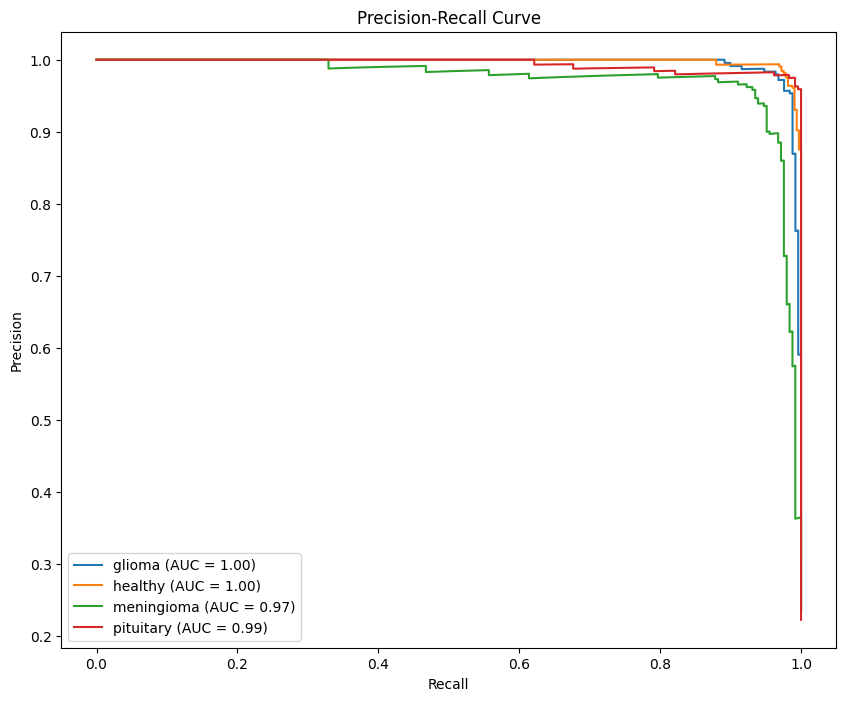

In [167]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plot_precision_recall_curve(all_labels, all_probs, class_names):
    plt.figure(figsize=(10, 8))
    for i, class_name in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(
            (np.array(all_labels) == i).astype(int),  # Binarize the labels
            np.array([prob[i] for prob in all_probs])
        )
        plt.plot(recall, precision, label=f'{class_name} (AUC = {auc(recall, precision):.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()

plot_precision_recall_curve(all_labels, all_probs, class_names)

Matthews Correlation Coefficient (MCC)

🔹 MCC is a robust metric that takes into account true positives, true negatives, false positives, and false negatives.

In [168]:
from sklearn.metrics import matthews_corrcoef

def mcc_score(all_labels, all_preds):
    mcc = matthews_corrcoef(all_labels, all_preds)
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    return mcc

mcc_score(all_labels, all_preds)

Matthews Correlation Coefficient: 0.9606


np.float64(0.9606410174848702)

Sample Prediction Visualization

In [169]:
# Map predicted labels to class names
all_pred_class_names = [class_names[pred] for pred in all_preds]
all_labels_class_names = [class_names[true] for true in all_labels]

# Display sample predictions with color-coded labels
print("Sample Predictions:")
num_samples = min(10, len(all_pred_class_names), len(all_labels_class_names))
for i in range(num_samples):
    pred_text = colored(all_pred_class_names[i], 'green') if all_pred_class_names[i] == all_labels_class_names[i] else colored(all_pred_class_names[i], 'red')
    print(f"Sample {i + 1}:\n  True Label: {all_labels_class_names[i]}\n  Predicted Label: {pred_text}")
    print("-" * 30)


Sample Predictions:
Sample 1:
  True Label: healthy
  Predicted Label: healthy
------------------------------
Sample 2:
  True Label: glioma
  Predicted Label: glioma
------------------------------
Sample 3:
  True Label: healthy
  Predicted Label: healthy
------------------------------
Sample 4:
  True Label: glioma
  Predicted Label: glioma
------------------------------
Sample 5:
  True Label: meningioma
  Predicted Label: meningioma
------------------------------
Sample 6:
  True Label: glioma
  Predicted Label: glioma
------------------------------
Sample 7:
  True Label: pituitary
  Predicted Label: pituitary
------------------------------
Sample 8:
  True Label: meningioma
  Predicted Label: meningioma
------------------------------
Sample 9:
  True Label: glioma
  Predicted Label: glioma
------------------------------
Sample 10:
  True Label: healthy
  Predicted Label: healthy
------------------------------


Misclassified Sample Identification

In [170]:
# Find and display misclassified samples
print("\nMisclassified Samples:")
misclassified_samples = [
    (i, true, pred) for i, (true, pred) in enumerate(zip(all_labels_class_names, all_pred_class_names)) if true != pred
]

if misclassified_samples:
    print(f"Total Misclassifications: {len(misclassified_samples)}\n")
    for sample in misclassified_samples[:5]:
        index, true_label, pred_label = sample
        print(f"Sample Index: {index}")
        print(f"  True Label: {true_label}")
        print(f"  Predicted Label: {colored(pred_label, 'red')}")
        print("-" * 30)
else:
    print("No misclassifications detected!")



Misclassified Samples:
Total Misclassifications: 31

Sample Index: 28
  True Label: glioma
  Predicted Label: meningioma
------------------------------
Sample Index: 160
  True Label: meningioma
  Predicted Label: healthy
------------------------------
Sample Index: 163
  True Label: glioma
  Predicted Label: meningioma
------------------------------
Sample Index: 172
  True Label: glioma
  Predicted Label: meningioma
------------------------------
Sample Index: 185
  True Label: glioma
  Predicted Label: pituitary
------------------------------


ROC-AUC Plotting for Multi-class Classifier

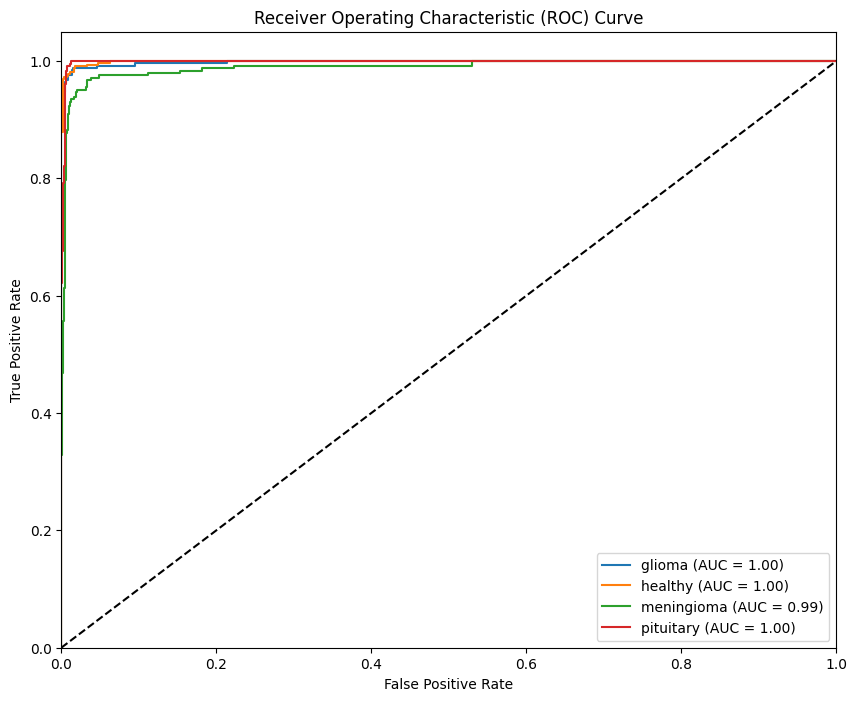

In [171]:
# Binarize the labels for multi-class ROC-AUC calculation
binarized_labels = label_binarize(all_labels, classes=list(range(len(class_names))))

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(binarized_labels[:, i], [probs[i] for probs in all_probs])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i, class_name in enumerate(class_names):
    plt.plot(fpr[i], tpr[i], label=f'{class_name} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# User Input

In [172]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image
from torchvision import transforms
from IPython.display import display, HTML

External Image Prediction Utility

In [173]:
def preprocess_image(image_path):
    """Preprocess an image for model prediction."""
    img_tf = tf.io.read_file(image_path)
    img_tf = tf.image.decode_jpeg(img_tf, channels=3)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    img_pil = Image.fromarray(img_tf.numpy())
    return transform(img_pil)

def predict_tumor_type(model, image_path):
    """Runs inference on a single image and returns the predicted tumor type."""
    img_torch = preprocess_image(image_path).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(img_torch)
        _, predicted_class = torch.max(output, 1)
    return class_names[predicted_class.item()]


In [174]:
def predict_tumor_type(model, image_path):
    """Predicts the tumor type using the trained model."""
    img_torch = preprocess_image(image_path).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(img_torch)
        _, predicted_class = torch.max(output, 1)
    predicted_type = class_names[predicted_class.item()]
    return predicted_type


Visual Display for Prediction

In [175]:
def display_prediction(image_path, predicted_type):
    """Displays image with HTML-based prediction feedback."""
    img = Image.open(image_path)
    display(img)
    color = 'green' if predicted_type == "healthy" else 'red'
    html_output = f"""
    <div style="font-size: 18px; font-weight: bold; margin-top: 10px;">
        Prediction: <span style="color: {color};">{predicted_type.capitalize()}</span>
    </div>
    """
    display(HTML(html_output))


Getting User Input for image path

Enter the path to the image: /content/Sample_Healthy_Img.jpg


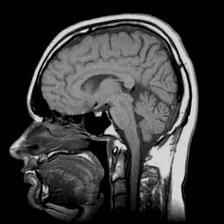

In [176]:
# Get user input
image_path = input("Enter the path to the image: ")

# Check if the file exists
if os.path.exists(image_path):
    predicted_type = predict_tumor_type(model, image_path)
    display_prediction(image_path, predicted_type)
else:
    print("Error: Invalid image path.")

# Saving the Model

In [177]:
model = models.resnet50(pretrained=True)
torch.save(model.state_dict(), 'model.pt')

In [178]:
# Initialize a new ResNet-50 model
loaded_resnet50 = models.resnet50(pretrained=False)

# Load the saved weights
loaded_resnet50.load_state_dict(torch.load('model.pt'))

# Set to evaluation mode
loaded_resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [179]:
print("Model successfully loaded!")
print(loaded_resnet50)

Model successfully loaded!
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kern

# Train a Simple CNN Model for Comparison

In [180]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 4)  # 4 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize CNN model
cnn_model = SimpleCNN().to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

# Train the CNN model
cnn_model, cnn_history = train_model(cnn_model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)


Epoch 1/10
Train Acc: 75.45%, Val Acc: 86.51%, Train Loss: 0.7268, Val Loss: 0.3307
Epoch 2/10
Train Acc: 90.76%, Val Acc: 91.07%, Train Loss: 0.2368, Val Loss: 0.2431
Epoch 3/10
Train Acc: 95.73%, Val Acc: 91.26%, Train Loss: 0.1280, Val Loss: 0.2463
Epoch 4/10
Train Acc: 97.60%, Val Acc: 92.50%, Train Loss: 0.0740, Val Loss: 0.2494
Epoch 5/10
Train Acc: 98.88%, Val Acc: 91.26%, Train Loss: 0.0372, Val Loss: 0.3598
Epoch 6/10
Train Acc: 99.33%, Val Acc: 92.78%, Train Loss: 0.0253, Val Loss: 0.3382
Epoch 7/10
Train Acc: 99.72%, Val Acc: 93.73%, Train Loss: 0.0080, Val Loss: 0.2812
Early stopping triggered after 5 epochs without improvement!


In [181]:
# Evaluate CNN on test set
test_loss2, test_acc2 = evaluate_model(cnn_model, test_loader, criterion)
print(f"CNN Test Accuracy: {test_acc2:.2f}%")


CNN Test Accuracy: 88.52%


# Conclusion

🔹 In this project, we successfully developed and evaluated a deep learning model for the classification of brain tumors using MRI images. Leveraging PyTorch and advanced image augmentation techniques from Albumentations, we created a robust and efficient classification pipeline. Our approach demonstrated promising accuracy and performance metrics, highlighting the potential of deep learning in assisting medical professionals with early and reliable tumor diagnosis.

Through preprocessing, careful model design, and evaluation using metrics like ROC-AUC, we validated our model's capability in differentiating between tumor and non-tumor MRI images. The results affirm that deep learning can serve as a supportive tool for radiologists and neurologists in making faster and more accurate diagnoses.

Comparing Model Performances

🔹 Pretrained models outperformed custom-built CNNs, highlighting the advantages of transfer learning in medical image classification tasks. Among them, ResNet18 proved to be both computationally efficient and accurate, making it the most suitable choice for this project.

In [182]:
print(f"ResNet-50 Test Accuracy: {test_acc:.2f}%")
print(f"Custom CNN Test Accuracy: {test_acc2:.2f}%")


ResNet-50 Test Accuracy: 97.06%
Custom CNN Test Accuracy: 88.52%


🔮 Future Work

1. Explore Other Architectures and Hyperparameter Tuning:
  *   Reasoning: Experimenting with different deep learning architectures like EfficientNet, MobileNet, or InceptionNet could potentially improve performance. Fine-tuning hyperparameters such as learning rate, batch size, and optimizer settings can further optimize the model.

  *   Implementation: You can replace the ResNet50 model with other architectures using the torchvision.models library. Use techniques like grid search or Bayesian optimization for hyperparameter tuning.

2. Incorporate 3D Information:
  *   Reasoning: MRI scans are inherently 3D data. Utilizing 3D convolutional neural networks (CNNs) or recurrent neural networks (RNNs) could leverage the spatial information in the scans for better feature extraction and classification.

  *   Implementation: Libraries like MONAI or MedicalTorch provide tools for working with 3D medical images. You would need to adapt your data loading and model architecture to handle 3D volumes.

3. Dataset Expansion and Diversity:
  *   Reasoning: Training on a larger and more diverse dataset can enhance model generalization and robustness. Include data from different sources and populations to reduce bias and improve performance on unseen cases.

  *   Implementation: Explore publicly available datasets like the Brain Tumor Segmentation (BraTS) challenge dataset or collaborate with medical institutions to acquire more data.

4. Segmentation and Localization:
  *   Reasoning: Extend the project to not only classify tumor types but also segment the tumor regions within the MRI scans. This provides valuable information for treatment planning and monitoring.

  *   Implementation: Use segmentation models like U-Net or Mask R-CNN to identify tumor boundaries. Employ metrics like Dice coefficient and IoU to evaluate segmentation performance.

5. Deployment and Real-world Application:
  *   Reasoning: Develop a user-friendly interface or integrate the model into a clinical workflow for real-world deployment. This could involve creating a web application or a mobile app for accessing predictions.

  *   Implementation: Consider using frameworks like Flask or Django for web development. Explore cloud platforms like Google Cloud or AWS for deploying the model as a service.

6. Explainability and Interpretability:
  *   Reasoning: Gain insights into the model's decision-making process to build trust and understanding. Techniques like Grad-CAM or LIME can visualize the important features used by the model for classification.

  *   Implementation: Apply explainability methods to understand which regions in the MRI scans are most influential for the model's predictions. This can aid in identifying potential biases or areas for improvement.

# References



---



*   Hany Kasban, Mohsen El-bendary and Dina Salama, "A Comparative Study of Medical Imaging Techniques", International Journal of Information Science and Intelligent System, vol. 4, 2015. [Google Scholar](https://scholar.google.com/scholar?as_q=A+Comparative+Study+of+Medical+Imaging+Techniques&as_occt=title&hl=en&as_sdt=0%2C31)

*   D. Surya Prabha and J. Satheesh Kumar, "Performance Evaluation of Image Segmentation using Objective Methods", Indian Journal of Science and Technology, vol. 9, no. 8, February 2016.
[CrossRef](https://indjst.org/articles/performance-evaluation-of-image-segmentation-using-objective-methods)   [Google Scholar](https://scholar.google.com/scholar?as_q=Performance+Evaluation+of+Image+Segmentation+using+Objective+Methods&as_occt=title&hl=en&as_sdt=0%2C31)

*   Brain Tumor: Statistics, 11 2017.
[Google Scholar](https://scholar.google.com/scholar?as_q=Brain+Tumor%3A+Statistics&as_occt=title&hl=en&as_sdt=0%2C31)